# check the grid of speedyfit

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units, constants
import joblib
from speedysedfit.tlustysed import rsed
from speedysedfit.broadsed import vgconv

# check kurucz93_z0.0_k2odfnew_sed.fits

In [69]:
fname = '/share/lijiao/speedyfit/modelgrids/kurucz93_z0.0_k2odfnew_sed.fits'
hdulist = fits.open(fname)

In [4]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    2                                                  
NAXIS2  =                    1                                                  
EXTEND  =                    T                                                  
LOGZ    = 'p00     '           / Metallicity wrt Solar                          
REF     = 'KURUCZ93'           / Table reference                                
WAVUNIT = 'angstrom'           / wavelength units                               
FLXUNIT = 'erg/s/cm2/A'        / flux units                                     
Z       =                  0.0                                                  

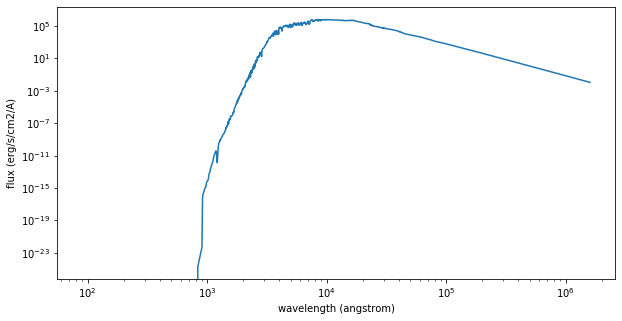

1221


In [13]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
data = hdulist[4].data
plt.plot(data['wavelength'], data['flux'])
plt.xlabel('wavelength (angstrom)')
plt.ylabel('flux (erg/s/cm2/A)')
plt.semilogx()
plt.semilogy()
plt.show()
print(len(data))

# check ifname = ikurucz93_z0.0_k2odfnew_sed_lawfitzpatrick2004_Rv3.10.fits

In [70]:
ifname = '/share/lijiao/speedyfit/modelgrids/ikurucz93_z0.0_k2odfnew_sed_lawfitzpatrick2004_Rv3.10.fits'
ihdulist = fits.open(ifname)

In [71]:
Teff = ihdulist[1].data['Teff']
logg = ihdulist[1].data['logg']
ebv = ihdulist[1].data['ebv']


In [73]:
ihdulist[1].data['GALEX.NUV']

array([1.58391356e+00, 1.18444858e+00, 8.86033755e-01, ...,
       4.69415925e+04, 3.44325839e+04, 2.52776405e+04])

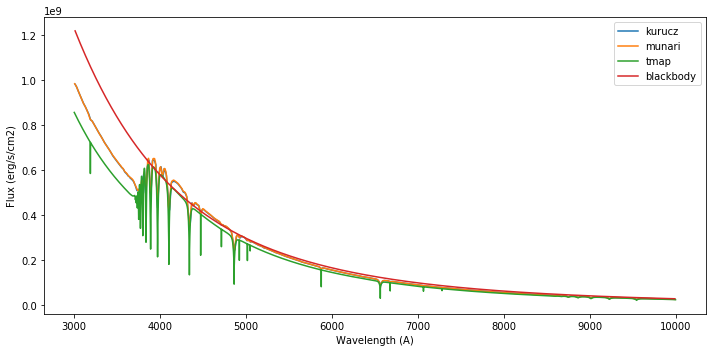

In [7]:
import pylab as pl
import numpy as np
from speedysedfit.model import get_table_single

grids = ['kurucz', 'munari', 'tmap', 'blackbody']

pl.figure(figsize=(10,5))

for grid in grids:

    wave, flux = get_table_single(teff=20000, logg=5.0, ebv=0.0, grid=grid)
    s = np.where((wave > 3000) & (wave<10000))
    pl.plot(wave[s], flux[s], label=grid)

pl.xlabel('Wavelength (A)')
pl.ylabel('Flux (erg/s/cm2)')
pl.legend(loc='best')
pl.tight_layout()
pl.show()

# compare TLUSTY SED and Kurucz SED

1221
len(wT) = 3385


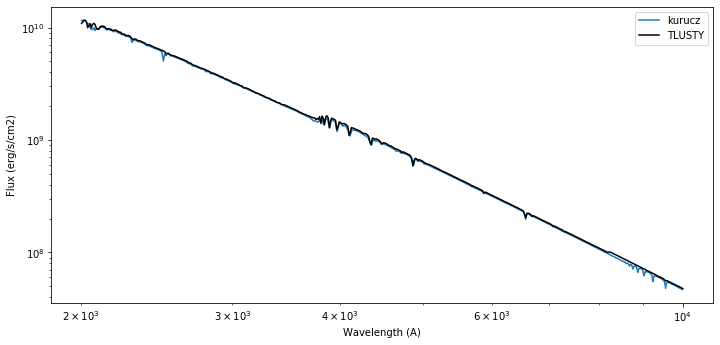

In [18]:
import numpy as np
from speedysedfit.model import get_table_single
from speedysedfit.tlustysed import rsed
from speedysedfit.broadsed import vgconv

ffname = '/share/lijiao/TLUSTY_grid/wangluqian/Tlusty/G30000g450v10.flux'
grids = ['kurucz',]# 'munari', 'tmap', 'blackbody']

pl.figure(figsize=(10,5))

for grid in grids:

    wave, flux = get_table_single(teff=30001, logg=4.5, ebv=0.0, grid=grid)
    print(len(wave))
    s = np.where((wave > 2000) & (wave<10000))
    pl.plot(wave[s], flux[s], label=grid)
    #pl.plot(wave, flux, label=grid)
    
  
wcor, fcor = rsed(ffname)
clight = 299792.458
#ind = (wcor > 2000) & (wcor < 10000)
#plt.plot(wcor[ind], fcor[ind], 'k')
#plt.plot(wave0[ind], flux0[ind], 'k')

w1, fbin = vgconv(wcor, fcor,clight/300, ppr=1)
print(f'len(wT) = {len(w1)}')
ind = (w1 > 2000) & (w1 < 10000)
fbin2 = np.interp(wave, w1, fbin)
plt.plot(w1[ind], fbin[ind], 'k', label='TLUSTY')
#plt.plot(w1, fbin, 'k', label='TLUSTY')
ind = (wave > 2000) & (wave < 20000)
#plt.plot(wave[ind], fbin2[ind], 'k')



pl.xlabel('Wavelength (A)')
pl.ylabel('Flux (erg/s/cm2)')
pl.legend(loc='best')
pl.tight_layout()
plt.semilogx()
plt.semilogy()
pl.show()